# Summary
- Target categories:
    - Good (suff. rating >= 80%)
    - Fair (suff. rating < 80% and >= 50%)
    - Poor (suff. rating < 50%)

# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## sklearn

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
# tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# model save
from sklearn.externals import joblib

## other

In [4]:
# upsampling with SMOTE
from imblearn import over_sampling
from imblearn.pipeline import Pipeline as imbPipeline

# Plot Settings

In [5]:
# format style
plt.style.use('fivethirtyeight')
# lineweight
plt.rc('lines', linewidth=3)
# figure size
plt.rc('figure', figsize=(12, 7))
# title fontsize
plt.rc('axes', titlesize=33) 
# axes label fontsize
plt.rc('axes', labelsize=28)
# axes values fontsize
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
# legend fontsize
plt.rc('legend', fontsize=18)

# Custom Functions

In [6]:
def rat_conv(rating):
    '''
    convert sufficiency rating to one of three categories
    '''
    if rating >= 80:
        return('good')
    elif rating < 50:
        return('poor')
    else:
        return ('fair')

# Space Log
Return range of numbers between two values in a log scale

In [29]:
def space_log(start, stop, number):
    return(np.exp(np.linspace(np.log(start), np.log(stop), number)))

## Feature Weight Sorting

In [7]:
def feat_sort(values, labels, ret_num='all', ret_pct=False):
    '''
    Return dataframe of sorted (by absolute value) feature weights
    values : feature weight values from analysis
    labels : names of each feature
    ret_num : number of top features to return
    ret_pct : return feature influence as a percentage of total
    '''
    
    df = pd.DataFrame(values, index=labels, columns=['feat_wgt'])
    # drop weights = 0
    df = df[df['feat_wgt'] != 0]
    # note which weights are positive
    df['positive'] = df['feat_wgt'] > 0
    # take absolute value of weights
    df['feat_wgt'] = df['feat_wgt'].apply(abs)
    # sort weights (largest to smalles)
    df.sort_values(by='feat_wgt', ascending=False, inplace=True)
    if ret_pct == True:
        # transform weights to percentages
        df['feat_wgt'] = df['feat_wgt'] / df['feat_wgt'].sum() * 100
    if ret_num == 'all':
        return(df)
    else:
        return(df.iloc[:ret_num, :])

# Data

In [8]:
df = pd.read_csv('data/bridges.csv', index_col=0)
df.head()

,COUNTY_CODE_003,FEATURES_DESC_006A,FACILITY_CARRIED_007,LOCATION_009,MIN_VERT_CLR_010,DETOUR_KILOS_019,AGE,TRAFFIC_LANES_ON_028A,TRAFFIC_LANES_UND_028B,ADT_029,...,APPR_KIND_044A,APPR_TYPE_044B,DECK_STRUCTURE_TYPE_107,SURFACE_TYPE_108A,MEMBRANE_TYPE_108B,DECK_PROTECTION_108C,DECK_COND_058,SUPERSTRUCTURE_COND_059,SUBSTRUCTURE_COND_060,SUFFICIENCY_RATING
51-1VA0158,99.0,'Gambo Creek ','Tisdale Rd ','1km N of Dahlgren Rd ',99.99,5.0,67.0,2.0,0,1650.0,...,0.0,0.0,1,0,0,0,5,4,4,13.0
51-1VA0575,740.0,'Dale St. & N&P RR ','Williams Avenue ','At Gate 36 and Elm Ave. ',99.99,1.0,65.0,2.0,2,5000.0,...,5.0,1.0,1,6,0,0,5,3,5,7.0
51-1VA0591,810.0,'Drainage Canal ','Golf Cart Path ','Near 9th Hole ',99.99,1.0,42.0,2.0,0,50.0,...,0.0,0.0,1,0,0,0,5,5,6,48.0
51-1VA2106,810.0,'Lake Whitehurst Outlet ','Guam Road ','1 KM NW of Ferry Rd ',99.99,5.0,53.0,2.0,0,500.0,...,0.0,0.0,1,0,0,0,5,6,6,79.5
51-1VA2107,810.0,'Eastern Shore RR ','Amphibious Drive ','0.2 KM W of Abbott Rd ',99.99,2.0,52.0,2.0,2,4000.0,...,3.0,2.0,1,0,0,0,6,5,6,63.4


In [9]:
# number of observations
len(df)

7803

# Pre-processing

In [10]:
# bridge identification
df_id = df.iloc[:, 0:4]

In [11]:
# numerical features
X_num = df.loc[:, 'MIN_VERT_CLR_010':'PERCENT_ADT_TRUCK_109']

## Categorical Data

In [12]:
# categorical features
X_cat = df.loc[:, 'TOLL_020':'DECK_PROTECTION_108C']

In [13]:
X_cat_enc = pd.get_dummies(X_cat)
X_cat_enc.head()

,TOLL_020,MAINTENANCE_021,FUNCTIONAL_CLASS_026,DESIGN_LOAD_031,MEDIAN_CODE_033,STRUCTURE_FLARED_035,HISTORY_037,SERVICE_ON_042A,SERVICE_UND_042B,STRUCTURE_KIND_043A,...,MEMBRANE_TYPE_108B_9,MEMBRANE_TYPE_108B_N,DECK_PROTECTION_108C_0,DECK_PROTECTION_108C_1,DECK_PROTECTION_108C_2,DECK_PROTECTION_108C_3,DECK_PROTECTION_108C_4,DECK_PROTECTION_108C_8,DECK_PROTECTION_108C_9,DECK_PROTECTION_108C_N
51-1VA0158,3.0,73.0,9.0,8.0,0.0,0.0,5.0,1,5,2,...,0,0,1,0,0,0,0,0,0,0
51-1VA0575,3.0,73.0,19.0,0.0,0.0,0.0,4.0,5,4,1,...,0,0,1,0,0,0,0,0,0,0
51-1VA0591,3.0,73.0,19.0,0.0,0.0,0.0,5.0,1,0,3,...,0,0,1,0,0,0,0,0,0,0
51-1VA2106,3.0,73.0,19.0,5.0,0.0,0.0,5.0,1,5,3,...,0,0,1,0,0,0,0,0,0,0
51-1VA2107,3.0,73.0,19.0,6.0,0.0,0.0,5.0,5,4,4,...,0,0,1,0,0,0,0,0,0,0


## Combine Categorical and Numeric Data

In [14]:
X = pd.concat([X_num, X_cat_enc], axis=1)
X.head()

,MIN_VERT_CLR_010,DETOUR_KILOS_019,AGE,TRAFFIC_LANES_ON_028A,TRAFFIC_LANES_UND_028B,ADT_029,APPR_WIDTH_MT_032,DEGREES_SKEW_034,NAV_VERT_CLR_MT_039,NAV_HORR_CLR_MT_040,...,MEMBRANE_TYPE_108B_9,MEMBRANE_TYPE_108B_N,DECK_PROTECTION_108C_0,DECK_PROTECTION_108C_1,DECK_PROTECTION_108C_2,DECK_PROTECTION_108C_3,DECK_PROTECTION_108C_4,DECK_PROTECTION_108C_8,DECK_PROTECTION_108C_9,DECK_PROTECTION_108C_N
51-1VA0158,99.99,5.0,67.0,2.0,0,1650.0,7.3,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
51-1VA0575,99.99,1.0,65.0,2.0,2,5000.0,8.1,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
51-1VA0591,99.99,1.0,42.0,2.0,0,50.0,6.1,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
51-1VA2106,99.99,5.0,53.0,2.0,0,500.0,9.1,9.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
51-1VA2107,99.99,2.0,52.0,2.0,2,4000.0,7.9,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0


## Target Data

In [15]:
# set target column values to categories
y = df.iloc[:, -1].apply(rat_conv)

## EDA

In [14]:
len(X_num.columns)

25

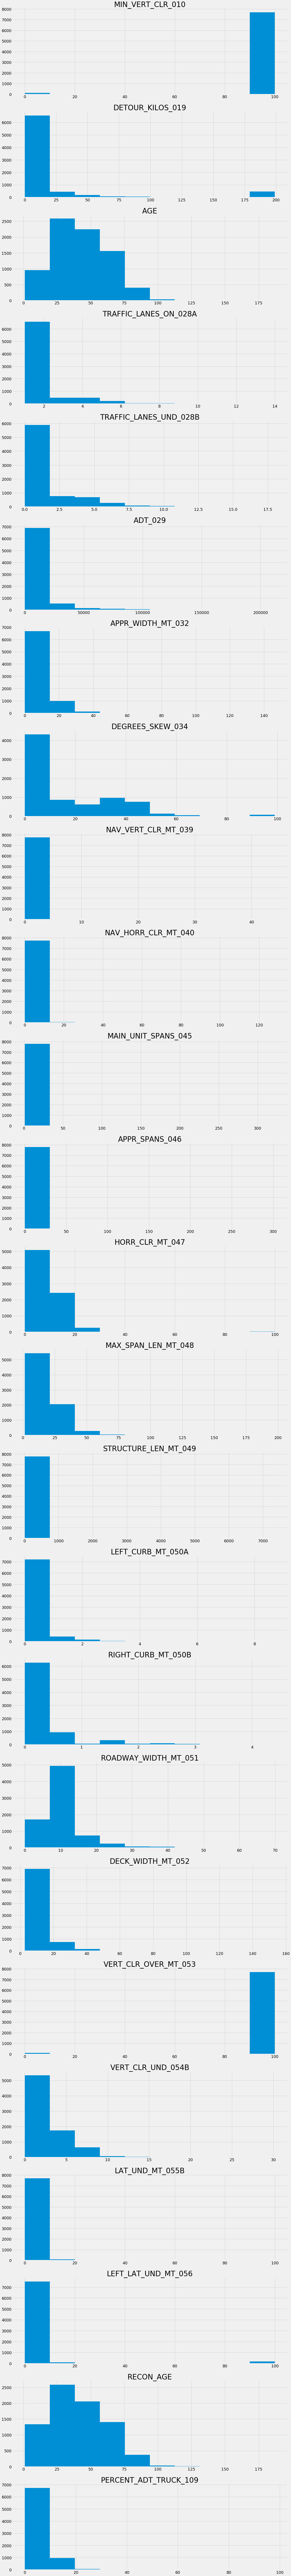

In [15]:
fig, ax = plt.subplots(nrows=len(X_num.columns), ncols=1, figsize=(20, 200))

for i, feat in enumerate(X_num):
    ax[i].set_title(feat)
    ax[i].hist(X_num[feat])

In [16]:
# number in each category
y.value_counts()

good    4018
fair    2920
poor     865
Name: SUFFICIENCY_RATING, dtype: int64

## Train/Test Split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Initial Modeling

## Logistic Regression

In [17]:
# model pipeline includes scaling
log_pipe = Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('model', LogisticRegression())
])

In [18]:
log_pipe.fit(X_train, y_train)
log_pred = log_pipe.predict(X_test)

In [19]:
print(metrics.classification_report(y_test, log_pred))

             precision    recall  f1-score   support

       fair       0.64      0.61      0.62       726
       good       0.76      0.81      0.79       993
       poor       0.65      0.57      0.61       232

avg / total       0.70      0.71      0.70      1951



In [20]:
metrics.confusion_matrix(y_test, log_pred)

array([[444, 233,  49],
       [168, 803,  22],
       [ 86,  14, 132]])

In [21]:
log_pipe.classes_

array(['fair', 'good', 'poor'], dtype=object)

In [22]:
log_imp = feat_sort(log_pipe.named_steps['model'].coef_[0], X_train.columns, 20)
print(log_pipe.classes_[0])
print(log_imp)

fair
                          feat_wgt  positive
ROADWAY_WIDTH_MT_051      1.795313     False
APPR_WIDTH_MT_032         0.708299      True
TRAFFIC_LANES_ON_028A     0.702455      True
AGE                       0.603879      True
STRUCTURE_LEN_MT_049      0.528977      True
ADT_029                   0.514464      True
MAIN_UNIT_SPANS_045       0.361204     False
RECON_AGE                 0.329739     False
OPEN_CLOSED_POSTED_041_P  0.243850     False
OPEN_CLOSED_POSTED_041_A  0.238762      True
APPR_SPANS_046            0.231315     False
APPR_RAIL_END_036D_N      0.206558      True
MEMBRANE_TYPE_108B_N      0.205913     False
NAV_VERT_CLR_MT_039       0.204399      True
DECK_PROTECTION_108C_N    0.187034      True
DETOUR_KILOS_019          0.176655      True
MEDIAN_CODE_033           0.172479      True
TRANSITIONS_036B_N        0.167535     False
DESIGN_LOAD_031           0.163693     False
MAX_SPAN_LEN_MT_048       0.155404     False


In [23]:
log_imp = feat_sort(log_pipe.named_steps['model'].coef_[1], X_train.columns, 20)
print(log_pipe.classes_[1])
print(log_imp)

good
                           feat_wgt  positive
ROADWAY_WIDTH_MT_051       2.500093      True
TRAFFIC_LANES_ON_028A      1.006107     False
APPR_WIDTH_MT_032          0.943591     False
AGE                        0.725145     False
ADT_029                    0.663026     False
APPR_SPANS_046             0.599099     False
MAIN_UNIT_SPANS_045        0.452122     False
STRUCTURE_LEN_MT_049       0.443915      True
DETOUR_KILOS_019           0.309306     False
DESIGN_LOAD_031            0.303798      True
MEMBRANE_TYPE_108B_N       0.218276      True
DECK_PROTECTION_108C_N     0.212342     False
SERVICE_UND_042B           0.211344     False
RECON_AGE                  0.204969      True
DECK_STRUCTURE_TYPE_107_3  0.199022     False
RAILINGS_036A_1            0.192196      True
APPR_KIND_044A             0.185255      True
RAILINGS_036A_0            0.179797     False
APPR_TYPE_044B             0.174876     False
MEDIAN_CODE_033            0.172893     False


In [24]:
log_imp = feat_sort(log_pipe.named_steps['model'].coef_[2], X_train.columns, 20)
print(log_pipe.classes_[2])
print(log_imp)

poor
                          feat_wgt  positive
ROADWAY_WIDTH_MT_051      1.701742     False
STRUCTURE_LEN_MT_049      1.212837     False
MAIN_UNIT_SPANS_045       1.099100      True
TRAFFIC_LANES_ON_028A     0.984103      True
NAV_HORR_CLR_MT_040       0.573474      True
APPR_SPANS_046            0.537163      True
DECK_WIDTH_MT_052         0.500947     False
APPR_RAIL_END_036D_N      0.482359     False
TOLL_020                  0.476779      True
RECON_AGE                 0.461942      True
DESIGN_LOAD_031           0.411238     False
TRANSITIONS_036B_N        0.389015      True
NAV_VERT_CLR_MT_039       0.372747     False
OPEN_CLOSED_POSTED_041_P  0.354975      True
OPEN_CLOSED_POSTED_041_A  0.347877     False
SERVICE_UND_042B          0.313741      True
ADT_029                   0.310597      True
DECK_PROTECTION_108C_1    0.272601     False
APPR_WIDTH_MT_032         0.231791      True
DECK_PROTECTION_108C_0    0.229857      True


### Refine

In [33]:
# try range of values for C and penalty hyperparameters
hyperparams = {'model__penalty':['l1', 'l2'], 'model__C': space_log(0.001, 100, 15)}

In [34]:
# tune model pipeline for recall
log_tune = RandomizedSearchCV(log_pipe, hyperparams, cv=5, random_state=0)

In [35]:
log_tune.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'model__penalty': ['l1', 'l2'], 'model__C': array([1.00000e-03, 2.27585e-03, 5.17947e-03, 1.17877e-02, 2.68270e-02,
       6.10540e-02, 1.38950e-01, 3.16228e-01, 7.19686e-01, 1.63789e+00,
       3.72759e+00, 8.48343e+00, 1.93070e+01, 4.39397e+01, 1.00000e+02])},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [36]:
# assign best hyperparameter values from tuning
best_penalty = log_tune.best_params_['model__penalty']
best_C = log_tune.best_params_['model__C']

In [37]:
best_penalty

'l1'

In [38]:
best_C

19.3069772888325

In [40]:
log_tune_pred = log_tune.predict(X_test)

In [41]:
print(metrics.classification_report(y_test, log_tune_pred))

             precision    recall  f1-score   support

       fair       0.64      0.61      0.62       726
       good       0.76      0.81      0.79       993
       poor       0.65      0.57      0.61       232

avg / total       0.70      0.71      0.70      1951



In [42]:
metrics.confusion_matrix(y_test, log_pred)

array([[444, 233,  49],
       [168, 803,  22],
       [ 86,  14, 132]])

## Random Forest

In [72]:
# model pipeline includes scaling
rf_pipe = imbPipeline([
    ('oversample', over_sampling.SMOTE(random_state=0)),
    ('model', RandomForestClassifier(random_state=0))
])

In [73]:
rf_pipe.fit(X_train, y_train)
rf_pred = rf_pipe.predict(X_test)

In [74]:
print(metrics.classification_report(y_test, rf_pred))

             precision    recall  f1-score   support

       fair       0.64      0.73      0.68       726
       good       0.83      0.77      0.80       993
       poor       0.64      0.55      0.59       232

avg / total       0.74      0.73      0.73      1951



In [75]:
metrics.confusion_matrix(y_test, rf_pred)

array([[527, 147,  52],
       [205, 769,  19],
       [ 90,  14, 128]])

In [47]:
rf_imp = feat_sort(rf_pipe.named_steps['model'].feature_importances_, X_train.columns, 20)
rf_imp

,feat_wgt,positive
AGE,0.059201,True
RECON_AGE,0.055899,True
DECK_WIDTH_MT_052,0.052851,True
ADT_029,0.047595,True
RAILINGS_036A_1,0.045300,True
DESIGN_LOAD_031,0.045143,True
OPEN_CLOSED_POSTED_041_A,0.040542,True
ROADWAY_WIDTH_MT_051,0.036489,True
STRUCTURE_LEN_MT_049,0.033957,True
OPEN_CLOSED_POSTED_041_P,0.033898,True


## Refine

In [76]:
# try range of values for hyperparameters

# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# number of features to consider at every split
max_features = np.arange(1, X.shape[1]+1)
# maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# method of selecting samples for training each tree
bootstrap = [True, False]

In [77]:
hyperparams = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

In [81]:
# tune model pipeline for recall
rf_tune = RandomizedSearchCV(RandomForestClassifier(random_state=0), hyperparams, cv=5, random_state=0)

In [82]:
rf_tune.fit(X_train, y_train)
rf_pred = rf_tune.predict(X_test)

In [83]:
print(metrics.classification_report(y_test, rf_pred))

             precision    recall  f1-score   support

       fair       0.70      0.72      0.71       726
       good       0.84      0.84      0.84       993
       poor       0.68      0.57      0.62       232

avg / total       0.77      0.77      0.77      1951



In [84]:
metrics.confusion_matrix(y_test, rf_pred)

array([[526, 154,  46],
       [140, 837,  16],
       [ 90,   9, 133]])

In [85]:
rf_tune.best_params_

{'n_estimators': 800,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 91,
 'max_depth': 50,
 'bootstrap': True}

In [87]:
# model pipeline includes scaling
rf_pipe = imbPipeline([
    ('oversample', over_sampling.SMOTE(random_state=0)),
    ('model', RandomForestClassifier(
        random_state=0,
        n_estimators=rf_tune.best_params_['n_estimators'],
        min_samples_split=rf_tune.best_params_['min_samples_split'],
        min_samples_leaf=rf_tune.best_params_['min_samples_leaf'],
        max_features=rf_tune.best_params_['max_features'],
        max_depth=rf_tune.best_params_['max_depth']
    ))
])

In [88]:
rf_pipe.fit(X_train, y_train)
rf_pred = rf_pipe.predict(X_test)

In [89]:
print(metrics.classification_report(y_test, rf_pred))

             precision    recall  f1-score   support

       fair       0.68      0.72      0.70       726
       good       0.84      0.81      0.83       993
       poor       0.65      0.62      0.64       232

avg / total       0.76      0.76      0.76      1951



In [90]:
metrics.confusion_matrix(y_test, rf_pred)

array([[526, 142,  58],
       [169, 805,  19],
       [ 80,   7, 145]])

In [95]:
rf_imp = feat_sort(rf_pipe.named_steps['model'].feature_importances_, X_train.columns)
rf_imp

,feat_wgt,positive
OPEN_CLOSED_POSTED_041_A,0.258519,True
DESIGN_LOAD_031,0.103882,True
ADT_029,0.075570,True
AGE,0.050973,True
ROADWAY_WIDTH_MT_051,0.044290,True
DETOUR_KILOS_019,0.039338,True
APPR_WIDTH_MT_032,0.025697,True
STRUCTURE_LEN_MT_049,0.025580,True
DECK_WIDTH_MT_052,0.024942,True
APPR_SPANS_046,0.023370,True


## SVM

In [ ]:
# model pipeline includes scaling
svm_pipe = Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('model', svm.SVC())
])

In [ ]:
svm_pipe.fit(X_train, y_train)
svm_pred = svm_pipe.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, svm_pred))

In [ ]:
metrics.confusion_matrix(y_test, svm_pred)